In [1]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=4685c9b60004e59d588cf269932939cef604656122a1240b4a02ac9218a91c5d
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
import sys
import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import matplotlib.pyplot as plt
np.random.seed(1234)


In [3]:
device = torch.device('cuda')

## Physics-informed Neural Networks

We will use a Fully Connected Neural Network to solve this PDE. The network will take in two features as input, $x$, the spatial co-ordinate, and $t$, the time co-ordinate. From these two inputs, the network should output the solution to the PDE at that point in space and time. For instance, the solution to a PDE given by $u_t = -u u_x + \nu u_{xx}$ is going to be the function $u(y,t)$. Our goal would be to pass in a given y-coordinate and time value to this network, and output the corresponding value of $f$. 

The first thing we'll do on the path towards implementing this is to define a *fully-connected* neural network with two nodes as input, one node as output, and several hidden layers in between. A good starting point would be to have 5 hidden layers with 50 neurons each, bias applied at each layer, and tanh() activation in between each linear layer.

In [4]:
class FCNN(torch.nn.Module):
 def __init__(self):
  super(FCNN, self).__init__()
  self.l1=torch.nn.Linear(2,50)
  self.l2=torch.nn.Linear(50, 50)
  self.l3=torch.nn.Linear(50, 50)
  self.l4=torch.nn.Linear(50, 50)
  self.l5=torch.nn.Linear(50, 50)
  self.l6=torch.nn.Linear(50, 50)
  self.l7=torch.nn.Linear(50, 1)
  self.act=torch.nn.Tanh()
 def forward(self, x):
  out = x.float()
  out=self.act(self.l1(out))
  out=self.act(self.l2(out))
  out=self.act(self.l3(out))
  out=self.act(self.l4(out))
  out=self.act(self.l5(out))
  out=self.act(self.l6(out))
  out=self.act(self.l7(out))
  return out

## Dataset Configuration

After you've defined the network architecture above, the next step is to create a dataset. Since our goal is to train a model that can predict the PDE solution at some arbitrary space co-ordinate and time co-ordinate, we need to randomly sample some space and time co-ordinates to act as the training input for the model.

To do so, we'll first:

1. Define a grid spanning all possible x, t combinations. If we have $N$ possible values of $x$ and $M$ possible values of t, we'll have $N_{samples} = N\times M$ combinations of $x$ and $t$.
2. Reshape this grid into a feature matrix, of shape ($N_{samples}$, $N_{features}$). We'll use $N_{samples}$ from (1.), and we have two  $N_{features}$ = 2 ($x$ and $t$).
3. Extract the vectors from the grid that define the intitial condition, and the left and right boundaries of the domain. We'll also reshape these vectors into a feature matrix.
4. Randomly sample these points to create a training set.

We'll use a direct MSE loss to make sure that the predictions of the network at the boundary and initial conditions are the correct values, and a loss based on the PDE residual for points in $(x,t)$ space that do not lie on the boundary or initial conditions. 

Some of the code to do this has been provided below, please fill in the blanks where indicated.

In [5]:
# TO-DO: a) Defining the dataset.
nu = 0.01/np.pi
N_u = 100
N_f = 10000
data = np.load('./q2_data.npy')
gt_solution = data.T
# 100 elements in the time dimension (Note, shape should be (100,1). You may have to reshape your vector.)
t_vector = np.linspace(0,1,100).reshape(100,1)
# 256 elements in the space dimension (Note, shape should be (256,1). You may have to reshape your vector.)
x_vector = np.linspace(-1,1,256).reshape(256,1)
# Create a grid of x, t values using np.meshgrid(), and store them in arrays called xx, and tt.
xx, tt = np.meshgrid(x_vector,t_vector)

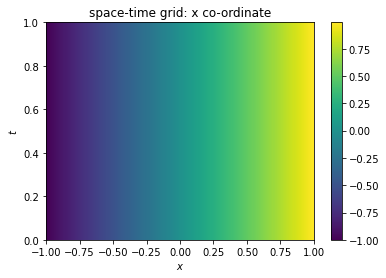

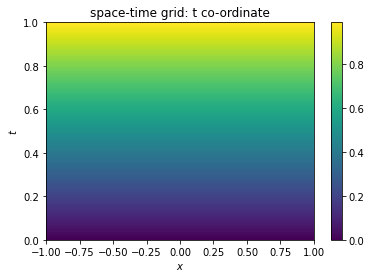

In [6]:
plt.pcolormesh(xx,tt, xx)
plt.title('space-time grid: x co-ordinate')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.colorbar()
plt.show()
plt.pcolormesh(xx, tt, tt)
plt.title('space-time grid: t co-ordinate')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.colorbar()
plt.show()

In [7]:
# TO-DO: Next, reshape the xx and tt arrays to be of shape (25600, 1), and stack them together (np.hstack),
# creating a combined x and t array of shape (25600, 2).
xx1 = xx.reshape(25600, 1)
tt1 = tt.reshape(25600, 1)
xt_combined_flat = np.hstack([xx1,tt1])
# Reshape the gt_solution data array to be of shape (25600, 1) in an array called u_flat
u_flat = gt_solution.reshape(25600,1) # u_flat is the ground truth data, defined for all 25600 combinations of x
# Domain bounds
# lb should be the minimum x and t values, stored as a numpy array of shape (1,2). The structure should be [x_m
lb_numpy = np.array([np.min(xx),np.min(tt)])
# ub should be the maximum x and t values, stored as a numpy array of shape (1,2). The structure should be [x_m
ub_numpy = np.array([np.max(xx),np.max(tt)])
# Define the initial conditions: t = 0.
# initial_conditions_xt is a 256 x 2 vector containing the x and t values at the initial condition.
# initial_condition_u is a 256 x 1 vector storing u at the initial condition
initial_condition_xt = np.vstack([xx[0,:],tt[0,:]]).T
u0 = np.zeros(len(x_vector))
u0[u0.shape[0]//2:] = 1
initial_condition_u = u0.reshape(-1,1)
# Defining the left boundary: (x = -1).
# left_boundary_xt is a 100 x 2 vector containing the x and t values at the left boundary.
# left_boundary_u is a 100 x 1 vector storing u at the left boundary.
left_boundary_xt = np.vstack([xx[:,0],tt[:,0]]).T
left_boundary_u = np.ones_like(t_vector).reshape(-1,1)
# Defining the right boundary: (x = 1)
# right_boundary_xt is a 100 x 2 vector containing the x and t values at the right boundary.
# right_boundary_u is a 100 x 1 vector storing u at the right boundary.
right_boundary_xt = np.vstack([xx[:,-1],tt[:,-1]]).T
right_boundary_u = np.ones_like(t_vector).reshape(-1,1)
# Stack the initial condition, left boundary condition, and right boundary condition together into one matrix
edge_samples_xt = np.vstack([initial_condition_xt, left_boundary_xt, right_boundary_xt])
# Sample randomly within the x,t space to create points for training
random_samples_xt = lb_numpy + (ub_numpy-lb_numpy)*lhs(2, N_f)
# Stack the [x,t] coordinates random samples with the boundary to create a training set for the PDE Loss
all_samples_xt = np.vstack((random_samples_xt, edge_samples_xt))
# Stack the ground truth data at the boundary, initial conditions
edge_samples_u = np.vstack([initial_condition_u, left_boundary_u, right_boundary_u])
# Randomly sample a training set for the MSE loss from the data at the initial and boundary conditions.
idx = np.random.choice(edge_samples_xt.shape[0], N_u, replace=False)
train_samples_xt = edge_samples_xt[idx, :]
train_samples_u = edge_samples_u[idx,:]


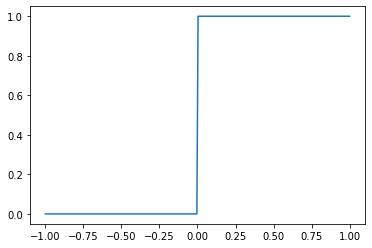

In [8]:
# Plot the initial condition as a function of x.
plt.plot(initial_condition_xt[:,0], initial_condition_u[:,0])
plt.show()

In [9]:
# TO-DO: Convert lower and upper bounds to torch tensors. No gradient is required for these.
lb_torch = torch.tensor(lb_numpy).float().to(device)
ub_torch = torch.tensor(ub_numpy).float().to(device)
# Convert x and t data to torch Tensors. Specify that the gradient is required while converting it to a Tensor.
# train_samples_xt and all_samples_xt are 2-column matrices with x and t as columns.
# Here we'll split these up, assigning the x_u and x_f variable to just
# be x, and t_u and t_f to just be t.
x_boundary_train = torch.tensor(train_samples_xt[:,0:1], requires_grad=True).float().to(device) 
t_boundary_train = torch.tensor(train_samples_xt[:,1:2], requires_grad=True).float().to(device)
x_sampled_train = torch.tensor(all_samples_xt[:,0:1], requires_grad=True).float().to(device)
t_sampled_train = torch.tensor(all_samples_xt[:,1:2], requires_grad=True).float().to(device)
# Convert train_samples_u to torch tensor, no gradient is required.
u_boundary_train = torch.tensor(train_samples_u).float().to(device)

## Training

In [10]:
# b): Initialize the Deep Neural Network, and put it on the GPU.
fcnn = FCNN().to(device)
# Use the following optimizer to optimize your function.
optimizer = torch.optim.LBFGS(
 fcnn.parameters(),
 lr=1.0,
 max_iter=2500,
 max_eval=3500,
 history_size=50,
 tolerance_grad=1e-5,
 tolerance_change=1.0 * np.finfo(float).eps,
 line_search_fn="strong_wolfe"
)
iter = 0
# c) Calling the network and calculating loss
## The function net_u takes in a neural network (fcnn), x, and t,
# and returns the prediction of the PDE solution at that combination of x and t.
def net_u(fcnn, x, t):
 # Call the fcnn network with the x and t co-ordinates, return the prediction.
 xt = torch.cat([x,t],dim=1)
 # return network output
 return fcnn(xt)
## The function net_f, takes in the net_u function, x, and t,
# and computes the residual of the PDE using gradients calculated from torch.autograd().
def net_f(x, t):
 # Calculate the residual of the PDE, using the gradients computed via autograd,
 # and the output of net_u as your predicted u.
 # Step 1: Using the function net_u, calculate the predicted u variable.
 predicted_u = net_u(fcnn,x,t)
 # Step 2: Compute the gradients used in the Burgers' equation PDE using torch.autograd().
 ux = torch.autograd.grad(predicted_u, x, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 ut = torch.autograd.grad(predicted_u, t, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 uxx = torch.autograd.grad(ux, x, grad_outputs = torch.ones_like(ux),
 retain_graph=True, create_graph=True)[0]
 # Step 3: Calculate the residual.
 residual = ut + predicted_u*ux - nu*uxx
 # return PDE residual
 return residual
iteration = 0
## The loss function will calculate the loss as a combination of the MSE loss on the boundaries,
# and the PDE residual loss elsewhere.
def loss_func():
 optimizer.zero_grad()
 # Predict the solution along the intitial and boundary conditions
 u_pred = net_u(fcnn,x_boundary_train,t_boundary_train)
 # Predict the solution at the sampled co-location points
 f_pred = net_f(x_sampled_train,t_sampled_train)
 # Compute MSE loss on (x,t) points that lie on initial and boundary conditions,
 # PDE loss from co-located sampled points, add them together
 mse_loss = torch.mean((u_pred - u_boundary_train)**2)
 pde_loss = torch.mean(f_pred**2)
 total_loss = mse_loss + pde_loss
 global iteration # iteration keeps track of the current iteration count
 # Uncomment line below to backpropagate loss
 total_loss.backward()
 # Print out iteration progress by uncommenting the following line:
 iteration = iteration + 1
 if iteration % 100 == 0:
  print(f'Iter {iteration}, Loss: {total_loss.item()}, Loss_u: {mse_loss.item()}, Loss_f: {pde_loss.item()}')
 return total_loss
# This initializes the gradients for training
fcnn.train()
# This carries out the entire optimization process with L-BFGS, by calling the
# loss_func function and updating the weights of the fcnn internally.
optimizer.step(loss_func)
loss_func()

Iter 100, Loss: 0.03188883513212204, Loss_u: 0.02292613685131073, Loss_f: 0.00896269828081131
Iter 200, Loss: 0.018512722104787827, Loss_u: 0.012785857543349266, Loss_f: 0.005726864095777273
Iter 300, Loss: 0.009111091494560242, Loss_u: 0.0034889201633632183, Loss_f: 0.005622171796858311
Iter 400, Loss: 0.0010934158926829696, Loss_u: 0.00028180639492347836, Loss_f: 0.0008116094977594912
Iter 500, Loss: 0.0004941343213431537, Loss_u: 0.00019277888350188732, Loss_f: 0.0003013554378412664
Iter 600, Loss: 0.00034288823371753097, Loss_u: 0.0001723795139696449, Loss_f: 0.0001705087342998013
Iter 700, Loss: 0.00025763121084310114, Loss_u: 0.0001131339740823023, Loss_f: 0.00014449724403675646
Iter 800, Loss: 0.00021497724810615182, Loss_u: 0.00010192480840487406, Loss_f: 0.00011305243970127776
Iter 900, Loss: 0.0001721238950267434, Loss_u: 9.023254824569449e-05, Loss_f: 8.189134678104892e-05
Iter 1000, Loss: 0.00016031450650189072, Loss_u: 8.385015826206654e-05, Loss_f: 7.646434823982418e-05
I

tensor(6.1130e-05, device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
# d) Given a 2-D array of space and time variables, predict the corresponding PDE solution, and the residual fr
def predict(xt):
 # As before, separate xt into vectors and convert these vectors of time and space into torch tensors that r
 x_torch = torch.tensor(xt[:,0:1], requires_grad=True).float().to(device) # assign x column of xt to x_torch
 t_torch = torch.tensor(xt[:,1:2], requires_grad=True).float().to(device) # assign t column of xt to x_torch
 fcnn.eval()
 # TO-DO: get predicted u and PDE residual from networks.
 u_pred = net_u(fcnn,x_torch,t_torch)
 f_pred = net_f(x_torch,t_torch)
 u = u_pred.detach().cpu().numpy()
 f = f_pred.detach().cpu().numpy()
 return u, f


In [12]:
# Predict the PDE solution for every combination of x and t
u_pred, f_pred = predict(xt_combined_flat)
# Compute the normalized L2 error of the solution
error_el2 = np.sum((u_flat - u_pred)**2)/(np.sum(u_flat**2))
print(f'Normalized L2 Error: error_el2')
# Compute the L1 error of the solution.
error_el1 = np.abs(u_flat - u_pred)


Normalized L2 Error: error_el2


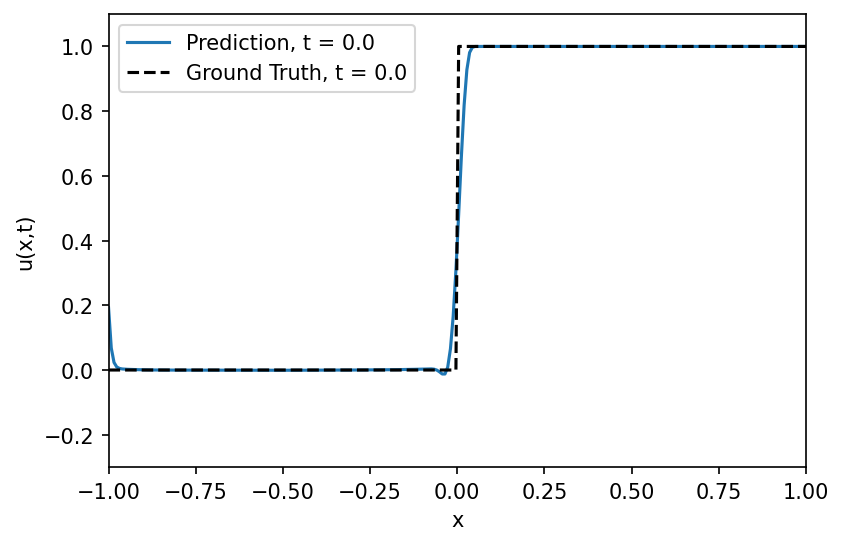

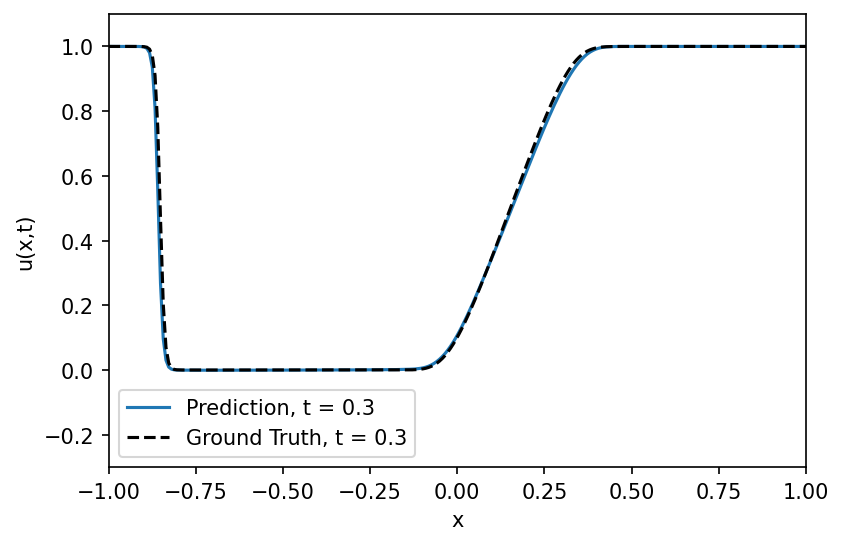

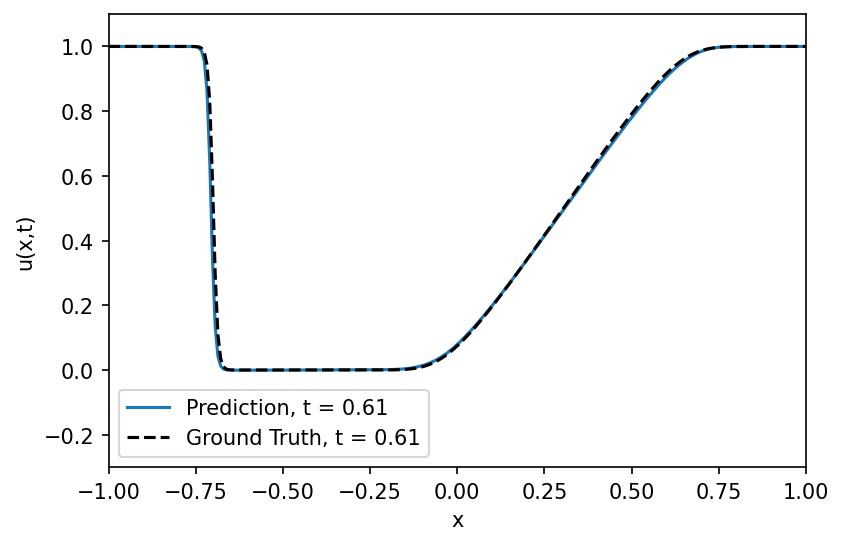

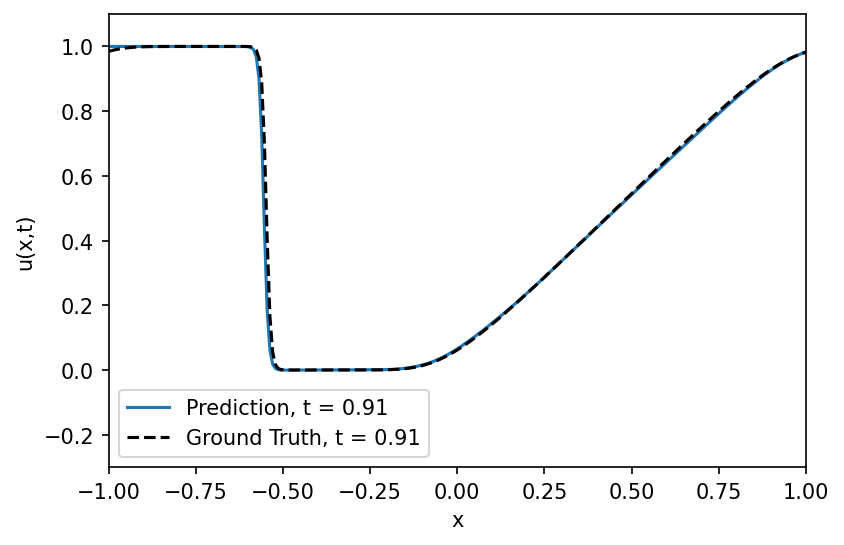

In [13]:
# Interpolate array for plotting.
u_pred_grid = griddata(xt_combined_flat, u_pred.flatten(), (xx, tt), method='cubic')
Error = np.abs(gt_solution - u_pred_grid)
for i in range(0, 100, 30):
  plt.figure(dpi = 150)
  plt.plot(x_vector[:,0],u_pred_grid[i,:], label = 'Prediction, t = {:.02}'.format(t_vector[i][0]))
  plt.plot(x_vector[:,0],gt_solution[i,:], 'k--', label = 'Ground Truth, t = {:.02}'.format(t_vector[i][0]))
  plt.legend()
  plt.ylim([-0.3,1.1])
  plt.xlim([-1,1])
  plt.xlabel('x')
  plt.ylabel('u(x,t)')
  plt.show()


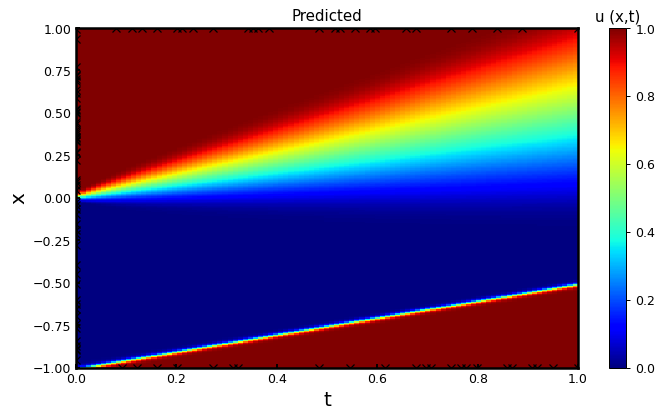

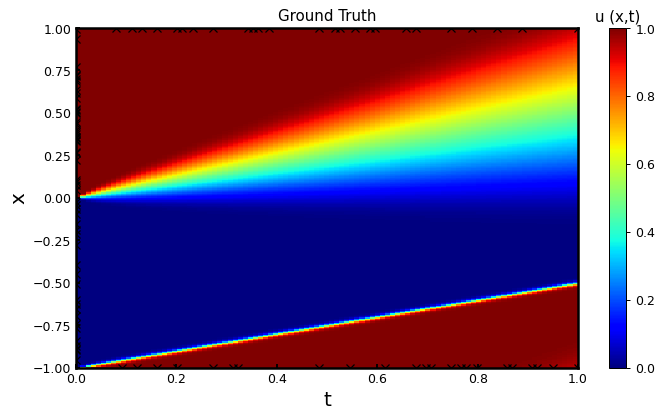

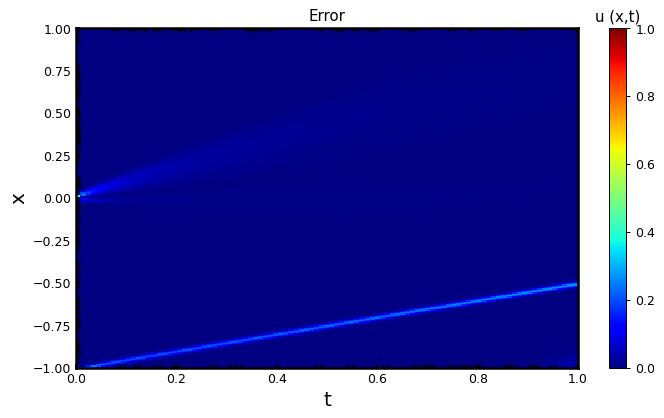

In [14]:
plt.figure(dpi = 90, figsize = [9,5])
plt.pcolormesh(tt.T,xx.T,u_pred_grid.T, cmap= 'jet', vmin =0, vmax = 1)
plt.ylabel('x', fontsize = 16)
plt.xlabel('t', fontsize = 16)
plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')
plt.title('Predicted')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
 ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
clb= plt.colorbar()
clb.ax.set_title('u (x,t)')
plt.show()
plt.figure(dpi = 90, figsize = [9,5])
plt.pcolormesh(tt.T,xx.T,gt_solution.T, cmap= 'jet', vmin =0, vmax = 1)
plt.ylabel('x', fontsize = 16)
plt.xlabel('t', fontsize = 16)
plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')
clb = plt.colorbar()
clb.ax.set_title('u (x,t)')
plt.title('Ground Truth')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
 ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
plt.show()
plt.figure(dpi = 90, figsize = [9,5])
plt.pcolormesh(tt.T,xx.T,Error.T, cmap= 'jet', vmin = 0, vmax = 1)
plt.ylabel('x', fontsize = 16)
plt.xlabel('t', fontsize = 16)
plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')
clb = plt.colorbar()
clb.ax.set_title('u (x,t)')
plt.title('Error')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
 ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
plt.show()


In [15]:
nu = 0.1
class FCNN2(torch.nn.Module):
 def __init__(self):
  super(FCNN2, self).__init__()
  self.l1=torch.nn.Linear(2,50)
  self.l2=torch.nn.Linear(50, 50)
  self.l3=torch.nn.Linear(50, 50)
  self.l4=torch.nn.Linear(50, 50)
  self.l5=torch.nn.Linear(50, 50)
  self.l6=torch.nn.Linear(50, 50)
  self.l7=torch.nn.Linear(50, 1)
  self.act=torch.nn.Tanh()
 def forward(self, x):
  out = x.float()
  out=self.act(self.l1(out))
  out=self.act(self.l2(out))
  out=self.act(self.l3(out))
  out=self.act(self.l4(out))
  out=self.act(self.l5(out))
  out=self.act(self.l6(out))
  out=self.act(self.l7(out))
  return out

In [16]:
# b): Initialize the Deep Neural Network, and put it on the GPU.
fcnn = FCNN2().to(device)
# Use the following optimizer to optimize your function.
optimizer = torch.optim.LBFGS(
 fcnn.parameters(),
 lr=1.0,
 max_iter=2500,
 max_eval=3500,
 history_size=50,
 tolerance_grad=1e-5,
 tolerance_change=1.0 * np.finfo(float).eps,
 line_search_fn="strong_wolfe"
)
iter = 0
# c) Calling the network and calculating loss
## The function net_u takes in a neural network (fcnn), x, and t,
# and returns the prediction of the PDE solution at that combination of x and t.
def net_u(fcnn, x, t):
 # Call the fcnn network with the x and t co-ordinates, return the prediction.
 xt = torch.cat([x,t],dim=1)
 # return network output
 return fcnn(xt)
## The function net_f, takes in the net_u function, x, and t,
# and computes the residual of the PDE using gradients calculated from torch.autograd().
def net_f(x, t):
 # Calculate the residual of the PDE, using the gradients computed via autograd,
 # and the output of net_u as your predicted u.
 # Step 1: Using the function net_u, calculate the predicted u variable.
 predicted_u = net_u(fcnn,x,t)
 # Step 2: Compute the gradients used in the Burgers' equation PDE using torch.autograd().
 ux = torch.autograd.grad(predicted_u, x, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 ut = torch.autograd.grad(predicted_u, t, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 uxx = torch.autograd.grad(ux, x, grad_outputs = torch.ones_like(ux),
 retain_graph=True, create_graph=True)[0]
 # Step 3: Calculate the residual.
 residual = ut + predicted_u*ux - nu*uxx
 # return PDE residual
 return residual
iteration = 0
## The loss function will calculate the loss as a combination of the MSE loss on the boundaries,
# and the PDE residual loss elsewhere.
def loss_func():
 optimizer.zero_grad()
 # Predict the solution along the intitial and boundary conditions
 u_pred = net_u(fcnn,x_boundary_train,t_boundary_train)
 # Predict the solution at the sampled co-location points
 f_pred = net_f(x_sampled_train,t_sampled_train)
 # Compute MSE loss on (x,t) points that lie on initial and boundary conditions,
 # PDE loss from co-located sampled points, add them together
 mse_loss = torch.mean((u_pred - u_boundary_train)**2)
 pde_loss = torch.mean(f_pred**2)
 total_loss = mse_loss + pde_loss
 global iteration # iteration keeps track of the current iteration count
 # Uncomment line below to backpropagate loss
 total_loss.backward()
 # Print out iteration progress by uncommenting the following line:
 iteration = iteration + 1
 if iteration % 100 == 0:
  print(f'Iter {iteration}, Loss: {total_loss.item()}, Loss_u: {mse_loss.item()}, Loss_f: {pde_loss.item()}')
 return total_loss
# This initializes the gradients for training
fcnn.train()
# This carries out the entire optimization process with L-BFGS, by calling the
# loss_func function and updating the weights of the fcnn internally.
optimizer.step(loss_func)
loss_func()

Iter 100, Loss: 0.032587915658950806, Loss_u: 0.027241002768278122, Loss_f: 0.005346914753317833
Iter 200, Loss: 0.022400276735424995, Loss_u: 0.018606629222631454, Loss_f: 0.00379364681430161
Iter 300, Loss: 0.014325319789350033, Loss_u: 0.011227421462535858, Loss_f: 0.0030978983268141747
Iter 400, Loss: 0.010551834478974342, Loss_u: 0.008799797855317593, Loss_f: 0.0017520361579954624
Iter 500, Loss: 0.007983488962054253, Loss_u: 0.006215544883161783, Loss_f: 0.001767943613231182
Iter 600, Loss: 0.00572222052142024, Loss_u: 0.0043987189419567585, Loss_f: 0.0013235016958788037
Iter 700, Loss: 0.0045033833011984825, Loss_u: 0.003475019009783864, Loss_f: 0.0010283644078299403
Iter 800, Loss: 0.003817756427451968, Loss_u: 0.002959638833999634, Loss_f: 0.0008581176516599953
Iter 900, Loss: 0.0032485018018633127, Loss_u: 0.0025572620797902346, Loss_f: 0.0006912397802807391
Iter 1000, Loss: 0.002917376346886158, Loss_u: 0.002313764300197363, Loss_f: 0.0006036121631041169
Iter 1100, Loss: 0.0

tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
# Predict the PDE solution for every combination of x and t
u_pred2, f_pred2 = predict(xt_combined_flat)
# Compute the normalized L2 error of the solution
error_el22 = np.sum((u_flat - u_pred2)**2)/(np.sum(u_flat**2))
print(f'Normalized L2 Error: {error_el22}')
# Compute the L1 error of the solution.
error_el12 = np.abs(u_flat - u_pred2)

Normalized L2 Error: 0.10060638755557182


In [18]:
nu = 1
class FCNN3(torch.nn.Module):
 def __init__(self):
  super(FCNN3, self).__init__()
  self.l1=torch.nn.Linear(2,50)
  self.l2=torch.nn.Linear(50, 50)
  self.l3=torch.nn.Linear(50, 50)
  self.l4=torch.nn.Linear(50, 50)
  self.l5=torch.nn.Linear(50, 50)
  self.l6=torch.nn.Linear(50, 50)
  self.l7=torch.nn.Linear(50, 1)
  self.act=torch.nn.Tanh()
 def forward(self, x):
  out = x.float()
  out=self.act(self.l1(out))
  out=self.act(self.l2(out))
  out=self.act(self.l3(out))
  out=self.act(self.l4(out))
  out=self.act(self.l5(out))
  out=self.act(self.l6(out))
  out=self.act(self.l7(out))
  return out

In [19]:
# b): Initialize the Deep Neural Network, and put it on the GPU.
fcnn = FCNN3().to(device)
# Use the following optimizer to optimize your function.
optimizer = torch.optim.LBFGS(
 fcnn.parameters(),
 lr=1.0,
 max_iter=2500,
 max_eval=3500,
 history_size=50,
 tolerance_grad=1e-5,
 tolerance_change=1.0 * np.finfo(float).eps,
 line_search_fn="strong_wolfe"
)
iter = 0
# c) Calling the network and calculating loss
## The function net_u takes in a neural network (fcnn), x, and t,
# and returns the prediction of the PDE solution at that combination of x and t.
def net_u(fcnn, x, t):
 # Call the fcnn network with the x and t co-ordinates, return the prediction.
 xt = torch.cat([x,t],dim=1)
 # return network output
 return fcnn(xt)
## The function net_f, takes in the net_u function, x, and t,
# and computes the residual of the PDE using gradients calculated from torch.autograd().
def net_f(x, t):
 # Calculate the residual of the PDE, using the gradients computed via autograd,
 # and the output of net_u as your predicted u.
 # Step 1: Using the function net_u, calculate the predicted u variable.
 predicted_u = net_u(fcnn,x,t)
 # Step 2: Compute the gradients used in the Burgers' equation PDE using torch.autograd().
 ux = torch.autograd.grad(predicted_u, x, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 ut = torch.autograd.grad(predicted_u, t, grad_outputs = torch.ones_like(predicted_u),
 retain_graph=True, create_graph=True)[0]

 uxx = torch.autograd.grad(ux, x, grad_outputs = torch.ones_like(ux),
 retain_graph=True, create_graph=True)[0]
 # Step 3: Calculate the residual.
 residual = ut + predicted_u*ux - nu*uxx
 # return PDE residual
 return residual
iteration = 0
## The loss function will calculate the loss as a combination of the MSE loss on the boundaries,
# and the PDE residual loss elsewhere.
def loss_func():
 optimizer.zero_grad()
 # Predict the solution along the intitial and boundary conditions
 u_pred = net_u(fcnn,x_boundary_train,t_boundary_train)
 # Predict the solution at the sampled co-location points
 f_pred = net_f(x_sampled_train,t_sampled_train)
 # Compute MSE loss on (x,t) points that lie on initial and boundary conditions,
 # PDE loss from co-located sampled points, add them together
 mse_loss = torch.mean((u_pred - u_boundary_train)**2)
 pde_loss = torch.mean(f_pred**2)
 total_loss = mse_loss + pde_loss
 global iteration # iteration keeps track of the current iteration count
 # Uncomment line below to backpropagate loss
 total_loss.backward()
 # Print out iteration progress by uncommenting the following line:
 iteration = iteration + 1
 if iteration % 100 == 0:
  print(f'Iter {iteration}, Loss: {total_loss.item()}, Loss_u: {mse_loss.item()}, Loss_f: {pde_loss.item()}')
 return total_loss
# This initializes the gradients for training
fcnn.train()
# This carries out the entire optimization process with L-BFGS, by calling the
# loss_func function and updating the weights of the fcnn internally.
optimizer.step(loss_func)
loss_func()

Iter 100, Loss: 0.05512808635830879, Loss_u: 0.04658493772149086, Loss_f: 0.008543147705495358
Iter 200, Loss: 0.03576532006263733, Loss_u: 0.02962479740381241, Loss_f: 0.006140521261841059
Iter 300, Loss: 0.03145923465490341, Loss_u: 0.028089718893170357, Loss_f: 0.0033695159945636988
Iter 400, Loss: 0.029044024646282196, Loss_u: 0.025573937222361565, Loss_f: 0.0034700867254287004
Iter 500, Loss: 0.027897490188479424, Loss_u: 0.024944275617599487, Loss_f: 0.0029532138723880053
Iter 600, Loss: 0.026576630771160126, Loss_u: 0.023914843797683716, Loss_f: 0.0026617860421538353
Iter 700, Loss: 0.025647955015301704, Loss_u: 0.023358236998319626, Loss_f: 0.002289717784151435
Iter 800, Loss: 0.02520989626646042, Loss_u: 0.022874297574162483, Loss_f: 0.002335598459467292
Iter 900, Loss: 0.024368910118937492, Loss_u: 0.022041328251361847, Loss_f: 0.0023275818675756454
Iter 1000, Loss: 0.02340501733124256, Loss_u: 0.02134879119694233, Loss_f: 0.002056226832792163
Iter 1100, Loss: 0.0227645598351

tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
# Predict the PDE solution for every combination of x and t
u_pred3, f_pred3 = predict(xt_combined_flat)
# Compute the normalized L2 error of the solution
error_el23 = np.sum((u_flat - u_pred3)**2)/(np.sum(u_flat**2))
print(f'Normalized L2 Error: {error_el23}')
# Compute the L1 error of the solution.
error_el12 = np.abs(u_flat - u_pred3)

Normalized L2 Error: 0.5277169681479611


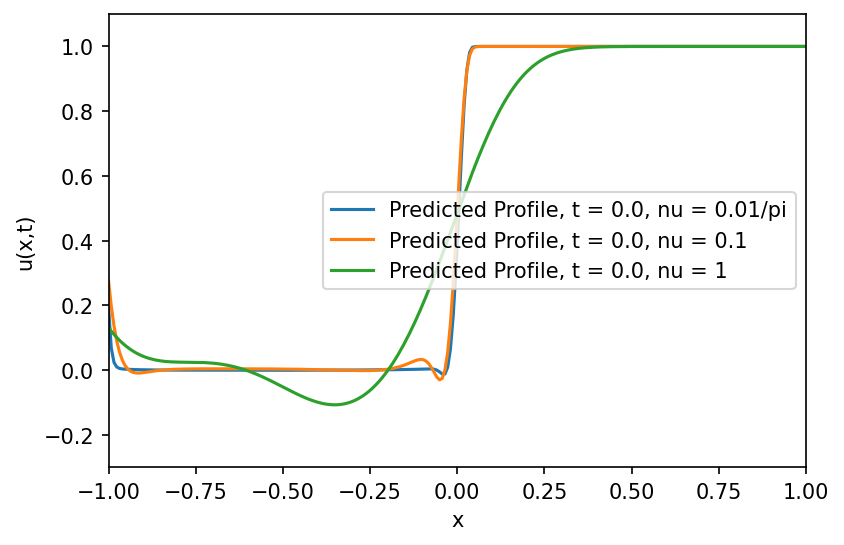

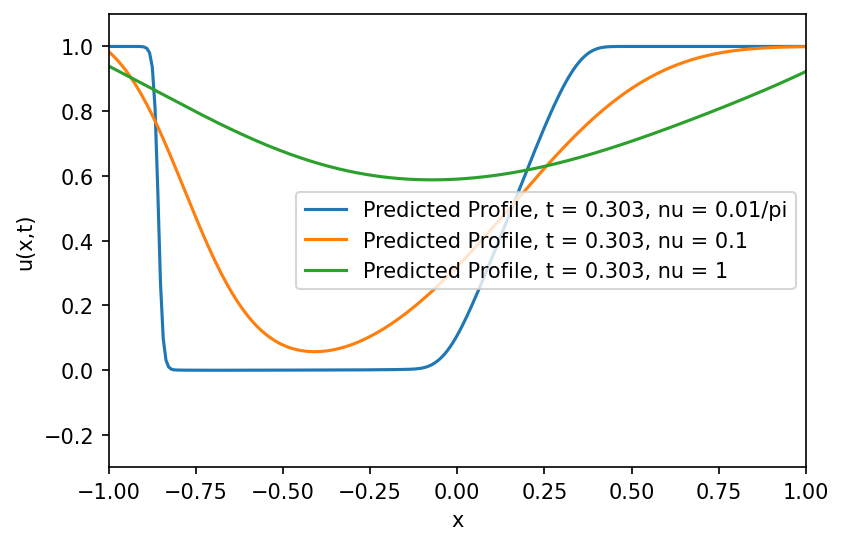

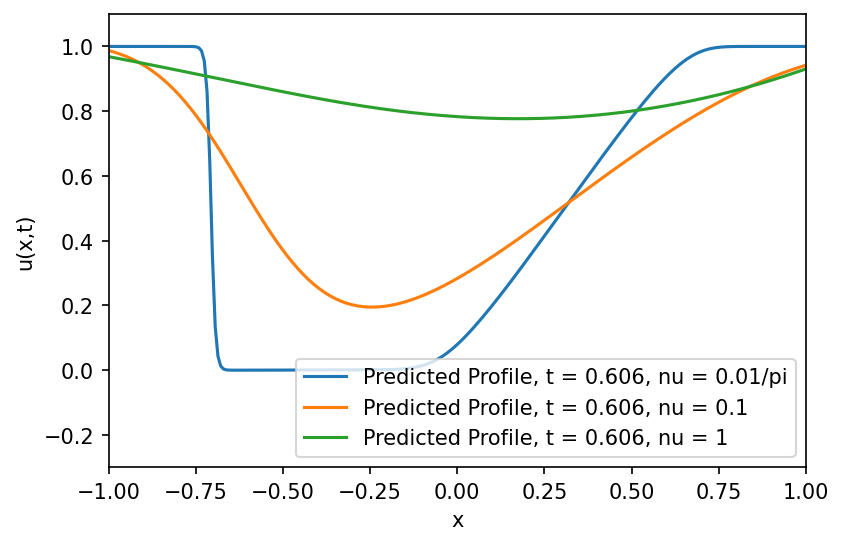

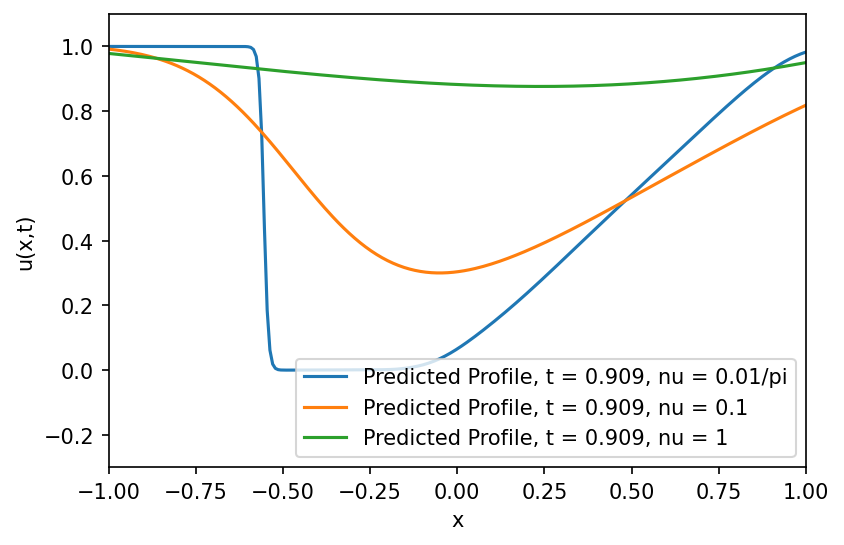

In [21]:
u_pred_grid = griddata(xt_combined_flat, u_pred.flatten(), (xx, tt), method='cubic')
u_pred_grid2 = griddata(xt_combined_flat, u_pred2.flatten(), (xx, tt), method='cubic')
u_pred_grid3= griddata(xt_combined_flat, u_pred3.flatten(), (xx, tt), method='cubic')
Error = np.abs(gt_solution - u_pred_grid)
for i in range(0, 100, 30):
 plt.figure(dpi = 150)
 plt.plot(x_vector[:,0],u_pred_grid[i,:], label = 'Predicted Profile, t = {:.03}, nu = 0.01/pi'.format(t_vector[i][0]))
 plt.plot(x_vector[:,0],u_pred_grid2[i,:], label = 'Predicted Profile, t = {:.03}, nu = 0.1'.format(t_vector[i][0]))
 plt.plot(x_vector[:,0],u_pred_grid3[i,:], label = 'Predicted Profile, t = {:.03}, nu = 1'.format(t_vector[i][0]))
 plt.legend()
 plt.ylim([-0.3,1.1])
 plt.xlim([-1,1])
 plt.xlabel('x')
 plt.ylabel('u(x,t)')
 plt.show()

As the value of nu increases it starts to deviate from the ground truth values. This happens becuase the ground truth is set at 0.01/pi. The losses will be greater for the value which is greater than 0.01/pi. This as the value of nu increases the profile starts to deviate. 

**(Theoretical Problem) - 5 points Briefly (∼2 sentences) describe how PyTorch’s AutoGrad functionality works and why it is useful
for implementing PINNs.**


The AutoGrad functionality is used to get the derivatives of the function. This is useful to get the derivatives in PINNS when there is backpropagation going on. This is the reason why we use autograd after the forward pass. 